# CSE 280A Project

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as smm

In [10]:
## Load the reference file (classification for each sample)
ref = pd.read_csv("../data/pcaa-master-platinum_set_2020.tsv", sep="\t", header=0, usecols=[0,7,8,12,13,28,32])
print(ref.shape)
ref.head()

(3212, 7)


,study,patient_barcode,sample_barcode,min_cnv,number_amp_region,sample_classification_nam_2019,sample_classification
0,PCWG,DO51086,SA530559,4,30,NaN,Non-circular
1,PCWG,DO48759,SA515463,4,5,NaN,Non-circular
2,PCWG,DO48916,SA517420,4,0,NaN,No SCNA detected
3,PCWG,DO51046,SA530430,4,2,NaN,No SCNA detected
4,PCWG,DO45251,SA501507,4,3,NaN,Circular


In [11]:
## Only keep TCGA samples
ref = ref[ref['study'] == 'TCGA']
print(ref.shape)
ref.head()

(1921, 7)


,study,patient_barcode,sample_barcode,min_cnv,number_amp_region,sample_classification_nam_2019,sample_classification
1291,TCGA,TCGA-02-2483,TCGA-02-2483-01,1,20,Distal,Heavily-rearranged
1292,TCGA,TCGA-02-2485,TCGA-02-2485-01,1,33,Circular,Circular
1293,TCGA,TCGA-04-1331,TCGA-04-1331-01,1,4,Linear,Non-circular
1294,TCGA,TCGA-04-1347,TCGA-04-1347-01,1,12,Circular,Circular
1295,TCGA,TCGA-04-1349,TCGA-04-1349-01,1,26,Distal,Heavily-rearranged


In [12]:
## Load the oncoprint matrix after querying genes against all TCGA studies
res = pd.read_csv("../data/PATIENT_DATA_oncoprint.tsv", sep="\t", header=0, skiprows=[1,2,3,4])
print(res.shape)
res.head()

(315, 10955)


,track_name,track_type,TCGA-ER-A195,TCGA-XK-AAJA,TCGA-CH-5788,TCGA-OR-A5JX,TCGA-CJ-4886,TCGA-EQ-A4SO,TCGA-CE-A3MD,TCGA-DM-A28K,TCGA-AY-6197,TCGA-AZ-6599,TCGA-FS-A1ZG,TCGA-AH-6903,TCGA-DD-A3A8,TCGA-HU-8604,TCGA-AA-3848,TCGA-EI-6510,TCGA-DM-A280,TCGA-5M-AATA,TCGA-CK-6751,TCGA-DD-A4NP,TCGA-VQ-A8DV,TCGA-D3-A8GQ,TCGA-BB-4217,TCGA-AD-6964,TCGA-95-7039,TCGA-BR-8368,TCGA-63-A5MW,TCGA-YL-A8SH,TCGA-A2-A0EY,TCGA-EJ-7784,TCGA-49-AAR2,TCGA-VQ-AA64,TCGA-GU-AATQ,TCGA-KC-A7F3,TCGA-EJ-5531,TCGA-S3-AA10,TCGA-CH-5748,TCGA-KK-A8IB,...,TCGA-ZG-A8QW,TCGA-ZG-A8QY,TCGA-ZG-A9LS,TCGA-ZG-A9LU,TCGA-ZG-A9ND,TCGA-ZH-A8Y6,TCGA-ZJ-A8QQ,TCGA-ZJ-A8QR,TCGA-ZJ-AAX8,TCGA-ZJ-AAXA,TCGA-ZJ-AB0H,TCGA-ZL-A9V6,TCGA-ZM-AA0D,TCGA-ZM-AA0E,TCGA-ZM-AA0F,TCGA-ZM-AA0H,TCGA-ZM-AA0N,TCGA-ZN-A9VQ,TCGA-ZN-A9VU,TCGA-ZP-A9D0,TCGA-ZS-A9CE,TCGA-ZT-A8OM,TCGA-ZU-A8S4,TCGA-91-A4BD,TCGA-91-6849,TCGA-91-8497,TCGA-93-7347,TCGA-93-7348,TCGA-95-7948,TCGA-96-A4JL,TCGA-97-A4M2,TCGA-97-7552,TCGA-97-8552,TCGA-98-A53C,TCGA-98-A53D,TCGA-98-A53H,TCGA-99-AA5R,TCGA-13-2066,TCGA-BP-4345,TCGA-OR-A5OG
0,APC,CNA,homdel_rec,homdel_rec,homdel_rec,Amplification,Amplification,NaN,NaN,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARHGEF12,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deep Deletion,Deep Deletion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,homdel_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCL11B,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
## Additional information of the oncoprint matrix
info = pd.read_csv("../data/PATIENT_DATA_oncoprint.tsv", sep="\t", header=0, skiprows=lambda x: x not in range(5))
print(info.shape)
info.head()

(4, 10955)


,track_name,track_type,TCGA-ER-A195,TCGA-XK-AAJA,TCGA-CH-5788,TCGA-OR-A5JX,TCGA-CJ-4886,TCGA-EQ-A4SO,TCGA-CE-A3MD,TCGA-DM-A28K,TCGA-AY-6197,TCGA-AZ-6599,TCGA-FS-A1ZG,TCGA-AH-6903,TCGA-DD-A3A8,TCGA-HU-8604,TCGA-AA-3848,TCGA-EI-6510,TCGA-DM-A280,TCGA-5M-AATA,TCGA-CK-6751,TCGA-DD-A4NP,TCGA-VQ-A8DV,TCGA-D3-A8GQ,TCGA-BB-4217,TCGA-AD-6964,TCGA-95-7039,TCGA-BR-8368,TCGA-63-A5MW,TCGA-YL-A8SH,TCGA-A2-A0EY,TCGA-EJ-7784,TCGA-49-AAR2,TCGA-VQ-AA64,TCGA-GU-AATQ,TCGA-KC-A7F3,TCGA-EJ-5531,TCGA-S3-AA10,TCGA-CH-5748,TCGA-KK-A8IB,...,TCGA-ZG-A8QW,TCGA-ZG-A8QY,TCGA-ZG-A9LS,TCGA-ZG-A9LU,TCGA-ZG-A9ND,TCGA-ZH-A8Y6,TCGA-ZJ-A8QQ,TCGA-ZJ-A8QR,TCGA-ZJ-AAX8,TCGA-ZJ-AAXA,TCGA-ZJ-AB0H,TCGA-ZL-A9V6,TCGA-ZM-AA0D,TCGA-ZM-AA0E,TCGA-ZM-AA0F,TCGA-ZM-AA0H,TCGA-ZM-AA0N,TCGA-ZN-A9VQ,TCGA-ZN-A9VU,TCGA-ZP-A9D0,TCGA-ZS-A9CE,TCGA-ZT-A8OM,TCGA-ZU-A8S4,TCGA-91-A4BD,TCGA-91-6849,TCGA-91-8497,TCGA-93-7347,TCGA-93-7348,TCGA-95-7948,TCGA-96-A4JL,TCGA-97-A4M2,TCGA-97-7552,TCGA-97-8552,TCGA-98-A53C,TCGA-98-A53D,TCGA-98-A53H,TCGA-99-AA5R,TCGA-13-2066,TCGA-BP-4345,TCGA-OR-A5OG
0,Study of origin,CLINICAL,"Skin Cutaneous Melanoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Adrenocortical Carcinoma (TCGA, PanCancer Atlas)","Kidney Renal Clear Cell Carcinoma (TCGA, PanCa...","Stomach Adenocarcinoma (TCGA, PanCancer Atlas)","Thyroid Carcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Skin Cutaneous Melanoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Liver Hepatocellular Carcinoma (TCGA, PanCance...","Stomach Adenocarcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Liver Hepatocellular Carcinoma (TCGA, PanCance...","Stomach Adenocarcinoma (TCGA, PanCancer Atlas)","Skin Cutaneous Melanoma (TCGA, PanCancer Atlas)","Head and Neck Squamous Cell Carcinoma (TCGA, P...","Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)","Lung Adenocarcinoma (TCGA, PanCancer Atlas)","Stomach Adenocarcinoma (TCGA, PanCancer Atlas)","Lung Squamous Cell Carcinoma (TCGA, PanCancer ...","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Breast Invasive Carcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Lung Adenocarcinoma (TCGA, PanCancer Atlas)","Stomach Adenocarcinoma (TCGA, PanCancer Atlas)","Bladder Urothelial Carcinoma (TCGA, PanCancer ...","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Breast Invasive Carcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)",...,"Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Prostate Adenocarcinoma (TCGA, PanCancer Atlas)","Cholangiocarcinoma (TCGA, PanCancer Atlas)","Cervical Squamous Cell Carcinoma (TCGA, PanCan...","Cervical Squamous Cell Carcinoma (TCGA, PanCan...","Cervical Squamous Cell Carcinoma (TCGA, PanCan...","Cervical Squamous Cell Carcinoma (TCGA, PanCan...","Cervical Squamous Cell Carcinoma (TCGA, PanCan...","Thymoma (TCGA, PanCancer Atlas)","Testicular Germ Cell Tumors (TCGA, PanCancer A...","Testicular Germ Cell Tumors (TCGA, PanCancer A...","Testicular Germ Cell Tumors (TCGA, PanCancer A...","Testicular Germ Cell Tumors (TCGA, PanCancer A...","Testicular Germ Cell Tumors (TCGA, PanCancer A...","Mesothelioma (TCGA, PanCancer Atlas)","Mesothelioma (TCGA, PanCancer Atlas)","Liver Hepatocellular Carcinoma (TCGA, PanCance...","Liver Hepatocellular Carcinoma

In [14]:
## Filter samples out - only keep samples/patients with ecDNA classification
res = res[['track_name', 'track_type'] + res.columns[res.columns.isin(ref['patient_barcode'])].tolist()]
print(res.shape)
res.head()


(315, 1902)


,track_name,track_type,TCGA-CH-5788,TCGA-FS-A1ZG,TCGA-DD-A3A8,TCGA-AD-6964,TCGA-A2-A0EY,TCGA-EJ-7784,TCGA-EJ-5531,TCGA-CH-5748,TCGA-AG-4008,TCGA-D3-A2JC,TCGA-68-7755,TCGA-64-1678,TCGA-04-1542,TCGA-BR-6801,TCGA-05-4389,TCGA-BR-8373,TCGA-D1-A16R,TCGA-DX-A23R,TCGA-A5-A0G2,TCGA-BS-A0UF,TCGA-CA-6717,TCGA-BS-A0UV,TCGA-AP-A051,TCGA-B5-A0JY,TCGA-F5-6814,TCGA-AG-A002,TCGA-AZ-4315,TCGA-AA-A00N,TCGA-FI-A2D0,TCGA-DI-A1BU,TCGA-FS-A1ZB,TCGA-EE-A17X,TCGA-05-4402,TCGA-DK-A3IU,TCGA-CG-5723,TCGA-EI-6917,TCGA-BS-A0U8,TCGA-AG-3727,...,TCGA-MR-A520,TCGA-RZ-AB0B,TCGA-V3-A9ZX,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E7,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EE,TCGA-V4-A9EF,TCGA-V4-A9EH,TCGA-V4-A9EJ,TCGA-V4-A9EK,TCGA-V4-A9EL,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EU,TCGA-V4-A9EV,TCGA-V4-A9EX,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F1,TCGA-V4-A9F2,TCGA-V4-A9F3,TCGA-V4-A9F5,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8K8,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
0,APC,CNA,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,Amplification,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARHGEF12,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCL11B,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
## Group the columns into ecDNA+ vs ecDNA-
## Strategy 1: ecDNA- = Non-circular; ecDNA+ = otherwise
# ecdna_neg = ref[ref['sample_classification'] == 'Non-circular']['patient_barcode']
# ecdna_pos = ref[ref['sample_classification'] != 'Non-circular']['patient_barcode']
# pos1 = list(res.columns[res.columns.isin(ecdna_pos)])
# print("Oncoprint1: {}, {}".format(pos1[-1], len(pos1)))
# cols_met1 = ['track_name', 'track_type'] + pos1 + list(res.columns[res.columns.isin(ecdna_neg)])
# df1 = res[cols_met1]
# print(df1.shape)
# df1.head()

In [39]:
## Save this oncoprint matrix
# df1.to_csv("../data/oncoprint_1.tsv", sep="\t", index=False)

In [105]:
# ## Strategy 2: ecDNA+ = Circular; ecDNA- = otherwise
# ecdna_pos = ref[ref['sample_classification'] == 'Circular']['patient_barcode']
# ecdna_neg = ref[ref['sample_classification'] != 'Circular']['patient_barcode']
# pos = res.columns[res.columns.isin(ecdna_pos)].tolist()
# print("Oncoprint: {}, {}".format(pos[-1], len(pos)))
# cols_met = ['track_name', 'track_type'] + pos + res.columns[res.columns.isin(ecdna_neg)].tolist()
# df = res[cols_met]
# print(df.shape)
# df.head()

In [49]:
## Save this oncoprint matrix
# df.to_csv("../data/oncoprint.tsv", sep="\t", index=False)

In [15]:
ref2 = ref[ref['patient_barcode'].isin(res.columns)]
print(ref2.shape)
ref2.head()

(1900, 7)


,study,patient_barcode,sample_barcode,min_cnv,number_amp_region,sample_classification_nam_2019,sample_classification
1291,TCGA,TCGA-02-2483,TCGA-02-2483-01,1,20,Distal,Heavily-rearranged
1292,TCGA,TCGA-02-2485,TCGA-02-2485-01,1,33,Circular,Circular
1293,TCGA,TCGA-04-1331,TCGA-04-1331-01,1,4,Linear,Non-circular
1294,TCGA,TCGA-04-1347,TCGA-04-1347-01,1,12,Circular,Circular
1295,TCGA,TCGA-04-1349,TCGA-04-1349-01,1,26,Distal,Heavily-rearranged


In [16]:
cnt = Counter(ref2['sample_classification'])
cnt

Counter({'Heavily-rearranged': 190,
         'Circular': 335,
         'Non-circular': 165,
         'No SCNA detected': 1041,
         'BFB': 169})

In [17]:
## Collect all possible entries for each track type
entry = {}
for track in res['track_type'].unique():
    entry[track] = set()
    df_sub = res[res['track_type'] == track]
    for i in range(2, len(res.columns)):
        entry[track] = entry[track].union(set(df_sub[df_sub.columns[i]].dropna().unique()))
entry


{'CNA': {'Amplification', 'Deep Deletion', 'amp_rec', 'homdel_rec'},
 'MUTATIONS': {'Inframe Mutation (putative driver)',
  'Inframe Mutation (putative passenger)',
  'Missense Mutation (putative driver)',
  'Missense Mutation (putative passenger)',
  'Truncating mutation (putative driver)',
  'Truncating mutation (putative passenger)',
  'splice',
  'splice_rec'},
 'MRNA': set(),
 'PROTEIN': set(),
 'FUSION': {'Fusion'}}

In [18]:
## Since the mRNA track and Protein track are empty, we delete these data
res = res[res['track_type'] != 'MRNA']
print(res.shape)
res = res[res['track_type'] != 'PROTEIN']
print(res.shape)
res.head()

(252, 1902)
(189, 1902)


,track_name,track_type,TCGA-CH-5788,TCGA-FS-A1ZG,TCGA-DD-A3A8,TCGA-AD-6964,TCGA-A2-A0EY,TCGA-EJ-7784,TCGA-EJ-5531,TCGA-CH-5748,TCGA-AG-4008,TCGA-D3-A2JC,TCGA-68-7755,TCGA-64-1678,TCGA-04-1542,TCGA-BR-6801,TCGA-05-4389,TCGA-BR-8373,TCGA-D1-A16R,TCGA-DX-A23R,TCGA-A5-A0G2,TCGA-BS-A0UF,TCGA-CA-6717,TCGA-BS-A0UV,TCGA-AP-A051,TCGA-B5-A0JY,TCGA-F5-6814,TCGA-AG-A002,TCGA-AZ-4315,TCGA-AA-A00N,TCGA-FI-A2D0,TCGA-DI-A1BU,TCGA-FS-A1ZB,TCGA-EE-A17X,TCGA-05-4402,TCGA-DK-A3IU,TCGA-CG-5723,TCGA-EI-6917,TCGA-BS-A0U8,TCGA-AG-3727,...,TCGA-MR-A520,TCGA-RZ-AB0B,TCGA-V3-A9ZX,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E7,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EE,TCGA-V4-A9EF,TCGA-V4-A9EH,TCGA-V4-A9EJ,TCGA-V4-A9EK,TCGA-V4-A9EL,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EU,TCGA-V4-A9EV,TCGA-V4-A9EX,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F1,TCGA-V4-A9F2,TCGA-V4-A9F3,TCGA-V4-A9F5,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8K8,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
0,APC,CNA,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,homdel_rec,Amplification,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARHGEF12,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCL11B,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
## Strategy 1: ecDNA+ = Circular; ecDNA- = otherwise
ecdna_pos = ref[ref['sample_classification'] == 'Circular']['patient_barcode']
ecdna_neg = ref[ref['sample_classification'] != 'Circular']['patient_barcode']
pos = res.columns[res.columns.isin(ecdna_pos)].tolist()
n_pos = len(pos)
print("Oncoprint: {}, {}".format(pos[-1], n_pos))
cols_met = ['track_name', 'track_type'] + pos + res.columns[res.columns.isin(ecdna_neg)].tolist()
df = res[cols_met]
print(df.shape)
df.head()

Oncoprint: TCGA-G2-A2EK, 335
(189, 1902)


,track_name,track_type,TCGA-D3-A2JC,TCGA-DX-A23R,TCGA-05-4402,TCGA-D7-6528,TCGA-A6-2677,TCGA-CV-6948,TCGA-A6-5656,TCGA-BR-4267,TCGA-A6-3810,TCGA-CG-4476,TCGA-D3-A2J6,TCGA-05-4397,TCGA-FF-8042,TCGA-EE-A3JI,TCGA-DK-A1AC,TCGA-IR-A3LK,TCGA-IG-A97I,TCGA-91-6840,TCGA-CG-4469,TCGA-DU-7010,TCGA-43-3394,TCGA-BR-4369,TCGA-06-0128,TCGA-FI-A2CY,TCGA-E2-A1LL,TCGA-IG-A3YB,TCGA-L5-A4OJ,TCGA-BW-A5NO,TCGA-05-5715,TCGA-BC-A217,TCGA-GV-A3JZ,TCGA-C8-A130,TCGA-BR-4357,TCGA-CG-4449,TCGA-05-4422,TCGA-IK-7675,TCGA-CN-4729,TCGA-49-4510,...,TCGA-MR-A520,TCGA-RZ-AB0B,TCGA-V3-A9ZX,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E7,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EE,TCGA-V4-A9EF,TCGA-V4-A9EH,TCGA-V4-A9EJ,TCGA-V4-A9EK,TCGA-V4-A9EL,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EU,TCGA-V4-A9EV,TCGA-V4-A9EX,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F1,TCGA-V4-A9F2,TCGA-V4-A9F3,TCGA-V4-A9F5,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8K8,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
0,APC,CNA,homdel_rec,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARHGEF12,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,Amplification,Deep Deletion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,homdel_rec,homdel_rec,Amplification,Amplification,Amplification,Amplification,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCL11B,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
## Save this oncoprint matrix
df.to_csv("../data/oncoprint1.tsv", sep="\t", index=False)

In [21]:
## Strategy 2: ecDNA+ = Circular; ecDNA- = no SCNA detected
ecdna_pos = ref[ref['sample_classification'] == 'Circular']['patient_barcode']
ecdna_neg = ref[ref['sample_classification'] == 'No SCNA detected']['patient_barcode']
pos = res.columns[res.columns.isin(ecdna_pos)].tolist()
print("Oncoprint: {}, {}".format(pos[-1], len(pos)))
neg = res.columns[res.columns.isin(ecdna_neg)].tolist()
n_neg2 = len(neg) 
cols_met = ['track_name', 'track_type'] + pos + neg
df2 = res[cols_met]
print(df2.shape)
df2.head()

Oncoprint: TCGA-G2-A2EK, 335
(189, 1378)


,track_name,track_type,TCGA-D3-A2JC,TCGA-DX-A23R,TCGA-05-4402,TCGA-D7-6528,TCGA-A6-2677,TCGA-CV-6948,TCGA-A6-5656,TCGA-BR-4267,TCGA-A6-3810,TCGA-CG-4476,TCGA-D3-A2J6,TCGA-05-4397,TCGA-FF-8042,TCGA-EE-A3JI,TCGA-DK-A1AC,TCGA-IR-A3LK,TCGA-IG-A97I,TCGA-91-6840,TCGA-CG-4469,TCGA-DU-7010,TCGA-43-3394,TCGA-BR-4369,TCGA-06-0128,TCGA-FI-A2CY,TCGA-E2-A1LL,TCGA-IG-A3YB,TCGA-L5-A4OJ,TCGA-BW-A5NO,TCGA-05-5715,TCGA-BC-A217,TCGA-GV-A3JZ,TCGA-C8-A130,TCGA-BR-4357,TCGA-CG-4449,TCGA-05-4422,TCGA-IK-7675,TCGA-CN-4729,TCGA-49-4510,...,TCGA-KN-8429,TCGA-KN-8431,TCGA-KN-8437,TCGA-KO-8405,TCGA-KO-8406,TCGA-KO-8407,TCGA-KO-8409,TCGA-KO-8410,TCGA-KO-8411,TCGA-KO-8417,TCGA-L6-A4ET,TCGA-MH-A55W,TCGA-MH-A560,TCGA-MH-A562,TCGA-MR-A520,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EF,TCGA-V4-A9EJ,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F2,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
0,APC,CNA,homdel_rec,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARHGEF12,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,Amplification,Deep Deletion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,homdel_rec,homdel_rec,Amplification,Amplification,Amplification,Amplification,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCL11B,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
## Save this oncoprint matrix
df2.to_csv("../data/oncoprint2.tsv", sep="\t", index=False)

## Using the strategy 1 matrix

In [22]:
print(df.shape)
df.head()

(189, 1902)


,track_name,track_type,TCGA-D3-A2JC,TCGA-DX-A23R,TCGA-05-4402,TCGA-D7-6528,TCGA-A6-2677,TCGA-CV-6948,TCGA-A6-5656,TCGA-BR-4267,TCGA-A6-3810,TCGA-CG-4476,TCGA-D3-A2J6,TCGA-05-4397,TCGA-FF-8042,TCGA-EE-A3JI,TCGA-DK-A1AC,TCGA-IR-A3LK,TCGA-IG-A97I,TCGA-91-6840,TCGA-CG-4469,TCGA-DU-7010,TCGA-43-3394,TCGA-BR-4369,TCGA-06-0128,TCGA-FI-A2CY,TCGA-E2-A1LL,TCGA-IG-A3YB,TCGA-L5-A4OJ,TCGA-BW-A5NO,TCGA-05-5715,TCGA-BC-A217,TCGA-GV-A3JZ,TCGA-C8-A130,TCGA-BR-4357,TCGA-CG-4449,TCGA-05-4422,TCGA-IK-7675,TCGA-CN-4729,TCGA-49-4510,...,TCGA-MR-A520,TCGA-RZ-AB0B,TCGA-V3-A9ZX,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E7,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EE,TCGA-V4-A9EF,TCGA-V4-A9EH,TCGA-V4-A9EJ,TCGA-V4-A9EK,TCGA-V4-A9EL,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EU,TCGA-V4-A9EV,TCGA-V4-A9EX,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F1,TCGA-V4-A9F2,TCGA-V4-A9F3,TCGA-V4-A9F5,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8K8,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
0,APC,CNA,homdel_rec,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARHGEF12,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,Amplification,Deep Deletion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,homdel_rec,homdel_rec,Amplification,Amplification,Amplification,Amplification,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCL11B,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [391]:
## Convert the oncoprint matrix into a numerical matrix
genes = df['track_name'].unique()
n_gene = len(genes)
n_neg = df.shape[1] - 2 - n_pos
print("{} ecDNA+ samples; {} ecDNA- samples".format(n_pos, n_neg))
L1 = np.zeros(shape=(len(genes), df.shape[1]-2))

335 ecDNA+ samples; 1565 ecDNA- samples


In [392]:
G1 = np.zeros(shape=(len(genes), df.shape[1]-2))

In [25]:
## All possible mutations
entry

{'CNA': {'Amplification', 'Deep Deletion', 'amp_rec', 'homdel_rec'},
 'MUTATIONS': {'Inframe Mutation (putative driver)',
  'Inframe Mutation (putative passenger)',
  'Missense Mutation (putative driver)',
  'Missense Mutation (putative passenger)',
  'Truncating mutation (putative driver)',
  'Truncating mutation (putative passenger)',
  'splice',
  'splice_rec'},
 'MRNA': set(),
 'PROTEIN': set(),
 'FUSION': {'Fusion'}}

In [50]:
## List of LoF mutations
loss = ['Truncating mutation (putative driver)', 'Truncating mutation (putative passenger)', \
        'Missense Mutation (putative driver)', 'Inframe Mutation (putative driver)', \
        'Deep Deletion', 'homdel_rec']

In [41]:
## List of GoF mutations
gain = ['Amplification', 'amp_rec']

In [42]:
## List of Ambiguous cases
ambiguous = ['splice', 'splice_rec', 'Missense Mutation (putative passenger)', 'Inframe Mutation (putative passenger']

In [36]:
## Iterate over each genes
gene = 'APC'
df_sel = df[(df['track_name'] == gene) & (df['track_type'] != 'FUSION')]
df_sel.head()
# for col in df_sel.columns[2:]:


,track_name,track_type,TCGA-D3-A2JC,TCGA-DX-A23R,TCGA-05-4402,TCGA-D7-6528,TCGA-A6-2677,TCGA-CV-6948,TCGA-A6-5656,TCGA-BR-4267,TCGA-A6-3810,TCGA-CG-4476,TCGA-D3-A2J6,TCGA-05-4397,TCGA-FF-8042,TCGA-EE-A3JI,TCGA-DK-A1AC,TCGA-IR-A3LK,TCGA-IG-A97I,TCGA-91-6840,TCGA-CG-4469,TCGA-DU-7010,TCGA-43-3394,TCGA-BR-4369,TCGA-06-0128,TCGA-FI-A2CY,TCGA-E2-A1LL,TCGA-IG-A3YB,TCGA-L5-A4OJ,TCGA-BW-A5NO,TCGA-05-5715,TCGA-BC-A217,TCGA-GV-A3JZ,TCGA-C8-A130,TCGA-BR-4357,TCGA-CG-4449,TCGA-05-4422,TCGA-IK-7675,TCGA-CN-4729,TCGA-49-4510,...,TCGA-MR-A520,TCGA-RZ-AB0B,TCGA-V3-A9ZX,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E7,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EE,TCGA-V4-A9EF,TCGA-V4-A9EH,TCGA-V4-A9EJ,TCGA-V4-A9EK,TCGA-V4-A9EL,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EU,TCGA-V4-A9EV,TCGA-V4-A9EX,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F1,TCGA-V4-A9F2,TCGA-V4-A9F3,TCGA-V4-A9F5,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8K8,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
0,APC,CNA,homdel_rec,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,APC,MUTATIONS,NaN,NaN,Truncating mutation (putative driver),Truncating mutation (putative driver),Truncating mutation (putative driver),Truncating mutation (putative driver),Truncating mutation (putative driver),Truncating mutation (putative driver),Truncating mutation (putative driver),Truncating mutation (putative driver),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),Missense Mutation (putative passenger),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [393]:
## Iterate over each genes & ignore FUSION at this moment
for i in range(n_gene):
    df_sel = df[(df['track_name'] == genes[i]) & (df['track_type'] != 'FUSION')]
    for j in range(2, df.shape[1]):
        ## Either way to count LoF
        # L1[i,j-2] = sum(df_sel[df_sel.columns[j]].isin(loss))      # method 1
        L1[i,j-2] = df_sel[df_sel.columns[j]].isin(loss).any()   # method 2
        G1[i,j-2] = df_sel[df_sel.columns[j]].isin(gain).any()


In [394]:
gain_pos = np.sum(G1[:,:n_pos], axis=1)
gain_neg = np.sum(G1[:,n_pos:], axis=1)
len(gain_pos), len(gain_neg)

(63, 63)

In [399]:
for i in range(n_gene):
    if gain_pos[i] == 0 and gain_neg[i] == 0: print(i)

57


In [397]:
genes = np.delete(genes, 57)
n_gene = len(genes)

In [400]:
gain_pos = np.delete(gain_pos, 57)
gain_neg = np.delete(gain_neg, 57)
len(gain_pos), len(gain_neg)

(62, 62)

In [401]:
fisher_gain, chi2_gain = np.zeros(n_gene), np.zeros(n_gene)
alpha = 0.05
for i in range(n_gene):
    # depends on how we computed the frequencies of mutations
    # e.g. method 2
    contigency_table = np.array([[gain_pos[i], gain_neg[i]], [n_pos - gain_pos[i], n_neg - gain_pos[i]]])
    # one-sided if our hypothesis is that LoF mutations is MORE frequent in ecDNA+ samples 
    # since we only have tumor supressor genes
    # _, fisher[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # or two-sided tests and use the volcano plots to determine the direction
    _, fisher_gain[i] = stats.fisher_exact(contigency_table, alternative="two-sided")
    _, chi2_gain[i], _, _ = stats.chi2_contingency(contigency_table)

In [402]:
rej_fisher_gain, fisher_gain, _, _ = smm.multipletests(fisher_gain, alpha=alpha, method='fdr_bh')
rej_chi2_gain, chi2_gain, _, _ = smm.multipletests(chi2_gain, alpha=alpha, method='fdr_bh')
fisher_gain = -np.log10(fisher_gain)
chi2_gain = -np.log10(chi2_gain)

In [403]:
## Compute the magnitude = log(#LoF / #not LoF)
magnitude_gain = np.zeros(n_gene)
for i in range(n_gene):
    magnitude_gain[i] = np.log2(sum(G1[i,:]) / (n_pos + n_neg - sum(G1[i,:])))

In [407]:
fisher_gain_onetail = np.zeros(n_gene)
alpha = 0.05
for i in range(n_gene):
    # depends on how we computed the frequencies of mutations
    # e.g. method 2
    contigency_table = np.array([[gain_pos[i], gain_neg[i]], [n_pos - gain_pos[i], n_neg - gain_pos[i]]])
    # one-sided if our hypothesis is that LoF mutations is MORE frequent in ecDNA+ samples 
    # since we only have tumor supressor genes
    # _, fisher[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # or two-sided tests and use the volcano plots to determine the direction
    _, fisher_gain_onetail[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # _, chi2_gain[i], _, _ = stats.chi2_contingency(contigency_table)

In [408]:
rej_fisher_gain_onetail, fisher_gain_onetail, _, _ = smm.multipletests(fisher_gain_onetail, alpha=alpha, method='fdr_bh')
fisher_gain_onetail = -np.log10(fisher_gain_onetail)

In [412]:
genes[rej_fisher_gain], genes[rej_fisher_gain_onetail], genes[rej_chi2_gain]

(array(['CEBPA', 'EXT1', 'SMARCA4', 'TNFAIP3'], dtype=object),
 array(['ATM', 'CDK6', 'CEBPA', 'EXT1', 'JAK2', 'MDM4', 'NOTCH1',
        'SMARCA4', 'TNFAIP3'], dtype=object),
 array(['ATM', 'CDK6', 'CEBPA', 'EXT1', 'IDH1', 'JAK2', 'MDM4', 'NOTCH1',
        'SMARCA4', 'TNFAIP3', 'WT1'], dtype=object))

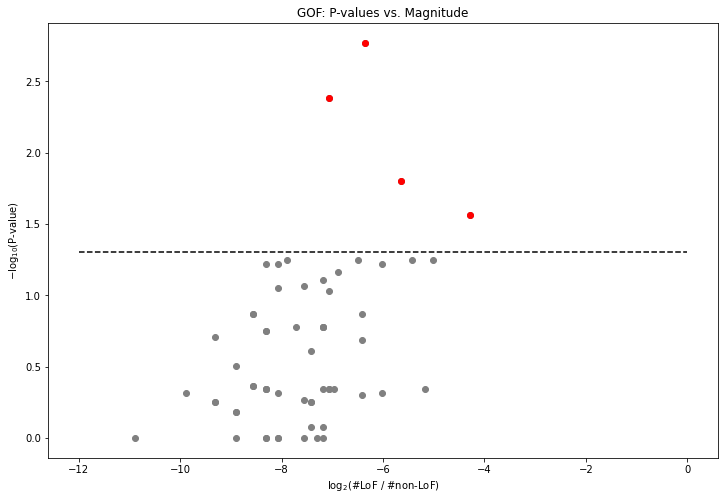

In [414]:
## Volcano plot
f, ax = plt.subplots(figsize=(12,8))
# fisher = -np.log10(fisher)
# chi2 = -np.log10(chi2)
ax.scatter(magnitude_gain, fisher_gain, color='grey')
# ax.scatter(magnitude_gain, chi2_gain, color='black')

ax.scatter(magnitude_gain[rej_fisher_gain], fisher_gain[rej_fisher_gain], color='red')
# ax.scatter(magnitude_gain[rej_chi2_gain], chi2_gain[rej_chi2_gain], color='blue')
# ax.scatter(magnitude_gain[rej_fisher_gain_onetail], fisher_gain_onetail[rej_fisher_gain_onetail], color='purple')
# ax.annotate(text=genes[rej_fisher][0], xy=(magnitude[rej_fisher], fisher[rej_fisher]), \
#     xytext=(magnitude[rej_fisher]-0.2, fisher[rej_fisher]-0.3), color='red')
# ax.scatter(magnitude[rej_chi2], chi2[rej_chi2], color='blue')
ax.plot(list(range(-12,1)), [-np.log10(alpha)] * len(list(range(-12,1))), color='black', linestyle='dashed')
ax.set_xlabel('$\log_2$(#LoF / #non-LoF)')
ax.set_ylabel('$-\log_{10}$(P-value)')
ax.set_title('GOF: P-values vs. Magnitude')
plt.show()


In [165]:
## Construct the contigency table and perform statistical tests
## i.e.    ecDNA+ | ecDNA-  
## Loss | 
## Not  |
## Sum up rows and generate 2 matrices where rows are genes, and columns are counts
loss_pos = np.sum(L1[:,:n_pos], axis=1)
loss_neg = np.sum(L1[:,n_pos:], axis=1)

fisher, chi2 = np.zeros(n_gene), np.zeros(n_gene)
alpha = 0.05
for i in range(n_gene):
    # depends on how we computed the frequencies of mutations
    # e.g. method 2
    contigency_table = np.array([[loss_pos[i], loss_neg[i]], [n_pos - loss_pos[i], n_neg - loss_neg[i]]])
    # one-sided if our hypothesis is that LoF mutations is MORE frequent in ecDNA+ samples 
    # since we only have tumor supressor genes
    # _, fisher[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # or two-sided tests and use the volcano plots to determine the direction
    _, fisher[i] = stats.fisher_exact(contigency_table, alternative="two-sided")
    _, chi2[i], _, _ = stats.chi2_contingency(contigency_table)

In [166]:
## Compute the magnitude = log(#LoF / #not LoF)
magnitude = np.zeros(n_gene)
for i in range(n_gene):
    magnitude[i] = np.log2(sum(L1[i,:]) / (n_pos + n_neg - sum(L1[i,:])))

In [167]:
## p-value correction
rej_fisher, fisher, _, _ = smm.multipletests(fisher, alpha=alpha, method='fdr_bh')
rej_chi2, chi2, _, _ = smm.multipletests(chi2, alpha=alpha, method='fdr_bh')

In [168]:
fisher = -np.log10(fisher)
chi2 = -np.log10(chi2)

In [171]:
genes[rej_fisher], genes[rej_chi2]

(array(['TP53'], dtype=object), array(['TP53'], dtype=object))

In [385]:
genes[rej_fisher][0]

'TP53'

In [405]:
## Volcano plot
f, ax = plt.subplots(figsize=(12,8))
# fisher = -np.log10(fisher)
# chi2 = -np.log10(chi2)
ax.scatter(magnitude, fisher, color='grey')
# ax.scatter(magnitude, chi2, color='black')

ax.scatter(magnitude[rej_fisher], fisher[rej_fisher], color='red')
ax.annotate(text=genes[rej_fisher][0], xy=(magnitude[rej_fisher], fisher[rej_fisher]), \
    xytext=(magnitude[rej_fisher]-0.2, fisher[rej_fisher]-0.3), color='red')
# ax.scatter(magnitude[rej_chi2], chi2[rej_chi2], color='blue')
ax.plot(list(range(-12,1)), [-np.log10(alpha)] * len(list(range(-12,1))), color='black', linestyle='dashed')
ax.set_xlabel('$\log_2$(#LoF / #non-LoF)')
ax.set_ylabel('$-\log_{10}$(P-value)')
ax.set_title('LOF: P-values vs. Magnitude')
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 62 but corresponding boolean dimension is 63

## Using strategy 2 matrix

In [79]:
print(df2.shape)
df2.head()

(189, 1378)


,track_name,track_type,TCGA-D3-A2JC,TCGA-DX-A23R,TCGA-05-4402,TCGA-D7-6528,TCGA-A6-2677,TCGA-CV-6948,TCGA-A6-5656,TCGA-BR-4267,TCGA-A6-3810,TCGA-CG-4476,TCGA-D3-A2J6,TCGA-05-4397,TCGA-FF-8042,TCGA-EE-A3JI,TCGA-DK-A1AC,TCGA-IR-A3LK,TCGA-IG-A97I,TCGA-91-6840,TCGA-CG-4469,TCGA-DU-7010,TCGA-43-3394,TCGA-BR-4369,TCGA-06-0128,TCGA-FI-A2CY,TCGA-E2-A1LL,TCGA-IG-A3YB,TCGA-L5-A4OJ,TCGA-BW-A5NO,TCGA-05-5715,TCGA-BC-A217,TCGA-GV-A3JZ,TCGA-C8-A130,TCGA-BR-4357,TCGA-CG-4449,TCGA-05-4422,TCGA-IK-7675,TCGA-CN-4729,TCGA-49-4510,...,TCGA-KN-8429,TCGA-KN-8431,TCGA-KN-8437,TCGA-KO-8405,TCGA-KO-8406,TCGA-KO-8407,TCGA-KO-8409,TCGA-KO-8410,TCGA-KO-8411,TCGA-KO-8417,TCGA-L6-A4ET,TCGA-MH-A55W,TCGA-MH-A560,TCGA-MH-A562,TCGA-MR-A520,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EF,TCGA-V4-A9EJ,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F2,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
0,APC,CNA,homdel_rec,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARHGEF12,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,Amplification,Deep Deletion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,homdel_rec,homdel_rec,Amplification,Amplification,Amplification,Amplification,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCL11B,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,homdel_rec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLM,CNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amplification,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
## Convert the oncoprint matrix into a numerical matrix
genes = df2['track_name'].unique()
n_gene = len(genes)
n_neg = df2.shape[1] - 2 - n_pos
print("{} ecDNA+ samples; {} ecDNA- samples".format(n_pos, n_neg))
L2 = np.zeros(shape=(len(genes), df2.shape[1]-2))

335 ecDNA+ samples; 1041 ecDNA- samples


In [212]:
G2 = np.zeros(shape=(63, df2.shape[1]-2))

In [213]:
## Iterate over each genes & ignore FUSION at this moment
for i in range(n_gene):
    df_sel = df2[(df2['track_name'] == genes[i]) & (df2['track_type'] != 'FUSION')]
    for j in range(2, df2.shape[1]):
        ## Either way to count LoF
        # L1[i,j-2] = sum(df_sel[df_sel.columns[j]].isin(loss))      # method 1
        L2[i,j-2] = df_sel[df_sel.columns[j]].isin(loss).any()   # method 2
        G2[i,j-2] = df_sel[df_sel.columns[j]].isin(gain).any()


In [188]:
## Construct the contigency table and perform statistical tests
## i.e.    ecDNA+ | ecDNA-  
## Loss |                   
## Not  |                
## Sum up rows and generate 2 matrices where rows are genes, and columns are counts
loss_pos2 = np.sum(L2[:,:n_pos], axis=1)
loss_neg2 = np.sum(L2[:,n_pos:], axis=1)

In [224]:
gain_pos2 = np.sum(G2[:,:n_pos], axis=1)
gain_neg2 = np.sum(G2[:,n_pos:], axis=1)
len(gain_neg2), len(gain_pos2)

(63, 63)

In [189]:
## Look for zero rows
for i in range(n_gene):
    if loss_pos2[i] == 0 and loss_neg2[i] == 0:
        print(i)

31


In [225]:
for i in range(63):
    if gain_pos2[i] == 0 and gain_neg2[i] == 0:
        print(i)

56
62


In [190]:
loss_pos2 = np.delete(loss_pos2, 31)
loss_neg2 = np.delete(loss_neg2, 31)
n_gene -= 1

In [226]:
gain_pos2 = np.delete(gain_pos2, [56,62])
gain_neg2 = np.delete(gain_neg2, [56,62])
n_gene = 61

In [256]:
fisher_2_gain_onetail= np.zeros(n_gene)
alpha = 0.05
for i in range(n_gene):
    # print(i)
    # depends on how we computed the frequencies of mutations
    # e.g. method 2
    contigency_table = np.array([[gain_pos2[i], gain_neg2[i]], [n_pos - gain_pos2[i], n_neg - gain_neg2[i]]])
    # one-sided if our hypothesis is that LoF mutations is MORE frequent in ecDNA+ samples 
    # since we only have tumor supressor genes
    # _, fisher[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # or two-sided tests and use the volcano plots to determine the direction
    _, fisher_2_gain_onetail[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # _, chi2_2_gain_onetail[i], _, _ = stats.chi2_contingency(contigency_table)

In [257]:
## p-value correction
rej_fisher_2_gain_onetail, fisher_2_gain_onetail, _, _ = smm.multipletests(fisher_2_gain_onetail, alpha=alpha, method='fdr_bh')
fisher_2_gain_onetail = -np.log10(fisher_2_gain_onetail)
# rej_chi2_2_gain, chi2_2_gain, _, _ = smm.multipletests(chi2_2_gain, alpha=alpha, method='fdr_bh')

In [245]:
fisher_2_gain, chi2_2_gain = np.zeros(n_gene), np.zeros(n_gene)
alpha = 0.05
for i in range(n_gene):
    # print(i)
    # depends on how we computed the frequencies of mutations
    # e.g. method 2
    contigency_table = np.array([[gain_pos2[i], gain_neg2[i]], [n_pos - gain_pos2[i], n_neg - gain_neg2[i]]])
    # one-sided if our hypothesis is that LoF mutations is MORE frequent in ecDNA+ samples 
    # since we only have tumor supressor genes
    # _, fisher[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # or two-sided tests and use the volcano plots to determine the direction
    _, fisher_2_gain[i] = stats.fisher_exact(contigency_table, alternative="two-sided")
    _, chi2_2_gain[i], _, _ = stats.chi2_contingency(contigency_table)

In [246]:
## p-value correction
rej_fisher_2_gain, fisher_2_gain, _, _ = smm.multipletests(fisher_2_gain, alpha=alpha, method='fdr_bh')
rej_chi2_2_gain, chi2_2_gain, _, _ = smm.multipletests(chi2_2_gain, alpha=alpha, method='fdr_bh')

In [247]:
fisher_2_gain = -np.log10(fisher_2_gain)
chi2_2_gain = -np.log10(chi2_2_gain)

In [248]:
len(fisher_2_gain)

61

In [191]:
fisher_2, chi2_2 = np.zeros(n_gene), np.zeros(n_gene)
alpha = 0.05
for i in range(n_gene):
    # print(i)
    # depends on how we computed the frequencies of mutations
    # e.g. method 2
    contigency_table = np.array([[loss_pos2[i], loss_neg2[i]], [n_pos - loss_pos2[i], n_neg - loss_neg2[i]]])
    # one-sided if our hypothesis is that LoF mutations is MORE frequent in ecDNA+ samples 
    # since we only have tumor supressor genes
    # _, fisher[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # or two-sided tests and use the volcano plots to determine the direction
    _, fisher_2[i] = stats.fisher_exact(contigency_table, alternative="two-sided")
    _, chi2_2[i], _, _ = stats.chi2_contingency(contigency_table)

In [192]:
n_gene = 62
fisher_onetail = np.zeros(n_gene)
for i in range(n_gene):
    # print(i)
    # depends on how we computed the frequencies of mutations
    # e.g. method 2
    contigency_table = np.array([[loss_pos2[i], loss_neg2[i]], [n_pos - loss_pos2[i], n_neg - loss_neg2[i]]])
    # one-sided if our hypothesis is that LoF mutations is MORE frequent in ecDNA+ samples 
    # since we only have tumor supressor genes
    _, fisher_onetail[i] = stats.fisher_exact(contigency_table, alternative="greater")
    # or two-sided tests and use the volcano plots to determine the direction
    # _, fisher_2[i] = stats.fisher_exact(contigency_table, alternative="two-sided")


In [193]:
rej_fisher_onetail, fisher_onetail, _, _ = smm.multipletests(fisher_onetail, alpha=alpha, method='fdr_bh')
fisher_onetail = -np.log10(fisher_onetail)

In [136]:
# for i in range(30,32):
#     contigency_table = np.array([[loss_pos2[i], loss_neg2[i]], [n_pos - loss_pos2[i], n_neg - loss_neg2[i]]])
#     print(contigency_table)
#     _, p1 = stats.fisher_exact(contigency_table, alternative="two-sided")
#     _, p2, _, _ = stats.chi2_contingency(contigency_table)
#     print("{}, {}".format(p1, p2))

In [194]:
## All zeros in this row
genes[31] 

'MDM4'

In [195]:
## Compute the magnitude = log(#LoF / #not LoF)
magnitude2 = np.zeros(n_gene)
for i in range(n_gene):
    magnitude2[i] = np.log2(sum(L2[i,:]) / (n_pos + n_neg - sum(L2[i,:])))

In [196]:
## p-value correction
rej_fisher_2, fisher_2, _, _ = smm.multipletests(fisher_2, alpha=alpha, method='fdr_bh')
rej_chi2_2, chi2_2, _, _ = smm.multipletests(chi2_2, alpha=alpha, method='fdr_bh')

In [197]:
fisher_2 = -np.log10(fisher_2)
chi2_2 = -np.log10(chi2_2)

In [198]:
genes = np.delete(genes, 31)
genes

array(['APC', 'ARHGEF12', 'ATM', 'BCL11B', 'BLM', 'BMPR1A', 'BRCA1',
       'BRCA2', 'CARS', 'CBFA2T3', 'CDH1', 'CDH11', 'CDK6', 'CDKN2C',
       'CEBPA', 'CHEK2', 'CREB1', 'CREBBP', 'CYLD', 'DDX5', 'EXT1',
       'EXT2', 'FBXW7', 'FH', 'FLT3', 'FOXP1', 'GPC3', 'IDH1', 'IL2',
       'JAK2', 'MAP2K4', 'MEN1', 'MLH1', 'MSH2', 'NF1', 'NF2', 'NOTCH1',
       'NPM1', 'NR4A3', 'NUP98', 'PALB2', 'PML', 'PTEN', 'RB1', 'RUNX1',
       'SDHB', 'SDHD', 'SMARCA4', 'SMARCB1', 'SOCS1', 'STK11', 'SUFU',
       'SUZ12', 'SYK', 'TCF3', 'TNFAIP3', 'TP53', 'TSC1', 'TSC2', 'VHL',
       'WRN', 'WT1'], dtype=object)

In [199]:
genes[rej_fisher_2], genes[rej_chi2_2], genes[rej_fisher_onetail]

(array(['IDH1', 'PTEN', 'TP53'], dtype=object),
 array(['IDH1', 'TP53'], dtype=object),
 array(['TP53'], dtype=object))

In [177]:
x = np.where(fisher_2 == max(fisher_2))
genes[x[0]]

array(['TP53'], dtype=object)

In [232]:
## Compute the magnitude = log(#LoF / #not LoF)
magnitude2_gain = np.zeros(n_gene)
for i in range(n_gene):
    magnitude2_gain[i] = np.log2(sum(G2[i,:]) / (n_pos + n_neg - sum(G2[i,:])))

In [251]:
genes = df2['track_name'].unique()
genes = np.delete(genes, [56,62])
len(genes)

61

In [254]:
genes[rej_fisher_2_gain], len(genes[rej_fisher_2_gain])

(array(['ATM', 'BLM', 'BRCA1', 'BRCA2', 'CDK6', 'CEBPA', 'CHEK2', 'EXT1',
        'FLT3', 'FOXP1', 'GPC3', 'IDH1', 'JAK2', 'MDM4', 'MLH1', 'MSH2',
        'NF1', 'NF2', 'PTEN', 'RB1', 'SDHB', 'SDHD', 'SMARCB1', 'SUFU',
        'TCF3', 'TSC2', 'WRN'], dtype=object),
 27)

In [323]:
genes = df2['track_name'].unique()
genes = np.delete(genes, [56,62])
genes[rej_fisher_2_gain]

array(['ATM', 'BLM', 'BRCA1', 'BRCA2', 'CDK6', 'CEBPA', 'CHEK2', 'EXT1',
       'FLT3', 'FOXP1', 'GPC3', 'IDH1', 'JAK2', 'MDM4', 'MLH1', 'MSH2',
       'NF1', 'NF2', 'PTEN', 'RB1', 'SDHB', 'SDHD', 'SMARCB1', 'SUFU',
       'TCF3', 'TSC2', 'WRN'], dtype=object)

In [255]:
genes[rej_chi2_2_gain], len(genes[rej_chi2_2_gain])

(array(['ATM', 'BRCA1', 'BRCA2', 'CDK6', 'CEBPA', 'CHEK2', 'EXT1', 'FLT3',
        'FOXP1', 'GPC3', 'IDH1', 'JAK2', 'MDM4', 'MLH1', 'MSH2', 'NF1',
        'NF2', 'PTEN', 'RB1', 'SDHB', 'SDHD', 'SMARCB1', 'SUFU', 'TCF3',
        'TSC2', 'WRN'], dtype=object),
 26)

In [260]:
genes[rej_fisher_2_gain_onetail], len(genes[rej_fisher_2_gain_onetail])

(array(['ATM', 'BLM', 'BRCA1', 'BRCA2', 'CDK6', 'CEBPA', 'CHEK2', 'EXT1',
        'FLT3', 'FOXP1', 'GPC3', 'IDH1', 'JAK2', 'MDM4', 'MLH1', 'MSH2',
        'NF1', 'NF2', 'PTEN', 'RB1', 'SDHB', 'SDHD', 'SMARCB1', 'SUFU',
        'TCF3', 'TSC2', 'WRN'], dtype=object),
 27)

In [331]:
fisher_2_gain

array([ 0.43899634,  0.43899634,  2.29240109,  0.2646908 ,  1.33369913,
        0.63327763,  1.91250674,  1.91250674,  0.16843126,  1.1464632 ,
        0.12240062,  0.16843126,  3.64910047, -0.        ,  4.3669997 ,
        1.91250674,  0.94795   ,  0.75254703,  0.16843126,  0.9728375 ,
        3.98362043,  1.1464632 ,  0.16034156,  0.79360548,  1.47331587,
        1.47331587,  1.91250674,  1.91250674,  0.2646908 ,  3.08693186,
       -0.        ,  1.91250674,  0.2646908 ,  2.75602265,  1.91250674,
        1.91250674,  2.29240109,  0.09675325,  0.94795   ,  0.77485224,
        0.12240062,  0.28888727, -0.        ,  1.47331587,  1.47331587,
        0.2646908 ,  1.47331587,  4.14405127,  0.77485224,  1.87891551,
       -0.        , -0.        ,  2.20731093,  0.63327763,  0.16034156,
        3.57641324,  0.43899634,  0.41813758,  1.91250674,  0.63327763,
        2.63262547])

In [ ]:
fisher_2_gain[rej]

-8.422064766172813 1.9125067394734299 BRCA1
-8.422064766172813 1.9125067394734299 BRCA2
-7.834997677126733 1.9125067394734299 CHEK2
-8.838153409425944 1.4733158703942246 FLT3
-7.093813673402728 1.9125067394734299 GPC3
-8.422064766172813 1.9125067394734299 IDH1
-7.834997677126733 1.9125067394734299 MDM4
-7.834997677126733 1.9125067394734299 MSH2
-7.834997677126733 1.9125067394734299 NF1
-8.838153409425944 1.4733158703942246 PTEN
-8.838153409425944 1.4733158703942246 RB1
-8.838153409425944 1.4733158703942246 SDHB
-6.712130128664117 1.8789155126141943 SMARCB1
-7.093813673402728 1.9125067394734299 TSC2


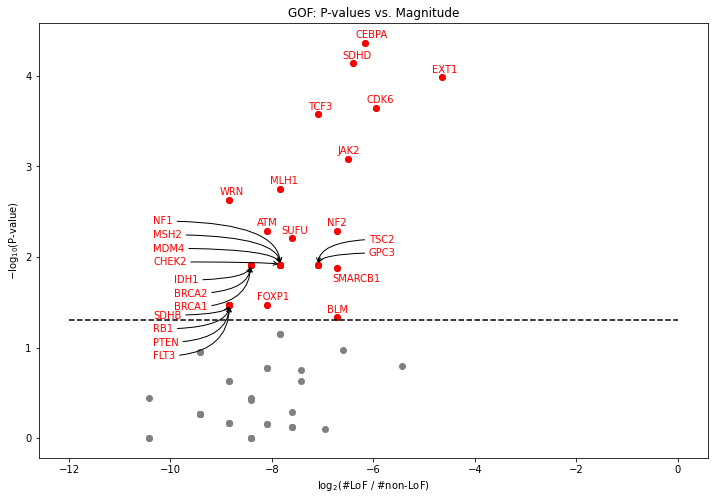

In [376]:
## Volcano plot
f, ax = plt.subplots(figsize=(12,8))
# fisher = -np.log10(fisher)
# chi2 = -np.log10(chi2)
ax.scatter(magnitude2_gain, fisher_2_gain, color='grey')
# ax.scatter(magnitude2_gain, chi2_2_gain, color='black')
# ax.scatter(magnitude2_gain, fisher_2_gain_onetail, color='green')

# sig_genes_fisher = magnitude[rej_fisher]
ax.scatter(magnitude2_gain[rej_fisher_2_gain], fisher_2_gain[rej_fisher_2_gain], color='red')
# ax.scatter(magnitude2_gain[rej_chi2_2_gain], chi2_2_gain[rej_chi2_2_gain], color='red')
# ax.scatter(magnitude2_gain[rej_fisher_2_gain], fisher_2_gain_onetail[rej_fisher_2_gain_onetail], color='purple')
a, b, c, d = 0, 0, 0, 0
for i, j, k in zip(magnitude2_gain[rej_fisher_2_gain], fisher_2_gain[rej_fisher_2_gain], genes[rej_fisher_2_gain]):
    if j < 2 and k not in ['FOXP1', 'BLM']:
        # ax.annotate(text=k, xy=(i,j), xytext=())
        print(i,j,k)
        if j < 1.5:
            ax.annotate(text=k, xy=(i,j), xytext=(i-1.5,j-0.6+a), color='red', \
                arrowprops=dict(arrowstyle='->', connectionstyle='angle3,angleA=0,angleB=-90'))
            a += 0.15
        elif i < -8:
            ax.annotate(text=k, xy=(i,j), xytext=(i-1.5,j-0.5+b), color='red', \
                arrowprops=dict(arrowstyle='->', connectionstyle='angle3,angleA=0,angleB=-90'))
            b += 0.15
        elif i > -7:
            ax.annotate(text=k, xy=(i,j), xytext=(i-0.1,j-0.15), color='red')
        elif i > -7.5:
            ax.annotate(text=k, xy=(i,j), xytext=(i+1, j+0.1+c), color='red', \
                arrowprops=dict(arrowstyle='->', connectionstyle='angle3,angleA=0,angleB=-90'))
            c += 0.15
        else:
            ax.annotate(text=k, xy=(i,j), xytext=(i-2.5,j+d), color='red', \
                arrowprops=dict(arrowstyle='->', connectionstyle='angle3,angleA=0,angleB=-90'))
            d += 0.15
        continue
    ax.annotate(text=k, xy=(i,j), xytext=(i-0.2,j+0.05), color='red')


ax.plot(list(range(-12,1)), [-np.log10(alpha)] * len(list(range(-12,1))), color='black', linestyle='dashed')
ax.set_xlabel('$\log_2$(#LoF / #non-LoF)')
ax.set_ylabel('$-\log_{10}$(P-value)')
ax.set_title('GOF: P-values vs. Magnitude')
plt.show()


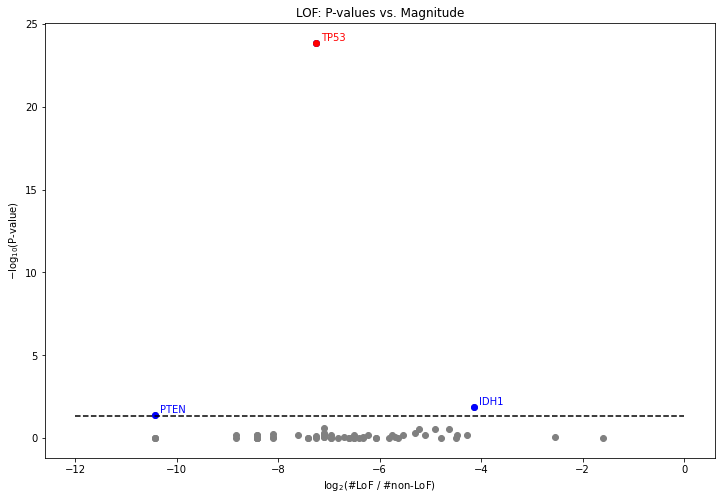

In [339]:
## Volcano plot
f, ax = plt.subplots(figsize=(12,8))
# fisher = -np.log10(fisher)
# chi2 = -np.log10(chi2)
ax.scatter(magnitude2, fisher_2, color='grey')
# ax.scatter(magnitude2, chi2_2, color='black')

# sig_genes_fisher = magnitude[rej_fisher]
ax.scatter(magnitude2[rej_fisher_2], fisher_2[rej_fisher_2], color='blue')
# ax.scatter(magnitude2[rej_chi2_2], chi2_2[rej_chi2_2], color='red')
# ax.scatter(magnitude2[rej_fisher_onetail], fisher_onetail[rej_fisher_onetail], color='purple')
ax.plot(list(range(-12,1)), [-np.log10(alpha)] * len(list(range(-12,1))), color='black', linestyle='dashed')
gene_name = ['IDH1', 'PTEN', 'TP53']
# genes[rej_fisher_2]
for i, j, k in zip(magnitude2[rej_fisher_2], fisher_2[rej_fisher_2], gene_name):
    if k == 'TP53': continue
    ax.annotate(text=k, xy=(i,j), xytext=(i+0.1, j+0.1), color='blue')

ax.scatter(magnitude2[56], fisher_2[56], color='red')
ax.annotate(text='TP53', xy=(magnitude2[56],fisher_2[56]), xytext=(magnitude2[56]+0.1,fisher_2[56]+0.1), color='red')

ax.set_xlabel('$\log_2$(#LoF / #non-LoF)')
ax.set_ylabel('$-\log_{10}$(P-value)')
ax.set_title('LOF: P-values vs. Magnitude')
plt.show()


In [ ]:
fisher_2[rej_fisher_onetail]

In [309]:
for i,j,k in zip([1],[2],[3]):
    print(i,j,k)

1 2 3


In [302]:
ind = np.where(fisher_onetail == max(fisher_onetail))[0]
# np.delete(df2['track_name'].unique(), 31)[rej_fisher_onetail]
# [rej_fisher_onetail]
np.arange(62)[rej_fisher_onetail]

array([56])

In [261]:
fusion = df2[df2['track_type'] == 'FUSION']
print(fusion.shape)
fusion.head()

(63, 1378)


,track_name,track_type,TCGA-D3-A2JC,TCGA-DX-A23R,TCGA-05-4402,TCGA-D7-6528,TCGA-A6-2677,TCGA-CV-6948,TCGA-A6-5656,TCGA-BR-4267,TCGA-A6-3810,TCGA-CG-4476,TCGA-D3-A2J6,TCGA-05-4397,TCGA-FF-8042,TCGA-EE-A3JI,TCGA-DK-A1AC,TCGA-IR-A3LK,TCGA-IG-A97I,TCGA-91-6840,TCGA-CG-4469,TCGA-DU-7010,TCGA-43-3394,TCGA-BR-4369,TCGA-06-0128,TCGA-FI-A2CY,TCGA-E2-A1LL,TCGA-IG-A3YB,TCGA-L5-A4OJ,TCGA-BW-A5NO,TCGA-05-5715,TCGA-BC-A217,TCGA-GV-A3JZ,TCGA-C8-A130,TCGA-BR-4357,TCGA-CG-4449,TCGA-05-4422,TCGA-IK-7675,TCGA-CN-4729,TCGA-49-4510,...,TCGA-KN-8429,TCGA-KN-8431,TCGA-KN-8437,TCGA-KO-8405,TCGA-KO-8406,TCGA-KO-8407,TCGA-KO-8409,TCGA-KO-8410,TCGA-KO-8411,TCGA-KO-8417,TCGA-L6-A4ET,TCGA-MH-A55W,TCGA-MH-A560,TCGA-MH-A562,TCGA-MR-A520,TCGA-V3-A9ZY,TCGA-V4-A9E5,TCGA-V4-A9E8,TCGA-V4-A9EC,TCGA-V4-A9ED,TCGA-V4-A9EF,TCGA-V4-A9EJ,TCGA-V4-A9EM,TCGA-V4-A9EO,TCGA-V4-A9ES,TCGA-V4-A9EZ,TCGA-V4-A9F0,TCGA-V4-A9F2,TCGA-V4-A9F7,TCGA-V4-A9F8,TCGA-VD-A8K7,TCGA-VD-A8KA,TCGA-VD-A8KD,TCGA-VD-A8KE,TCGA-VD-A8KF,TCGA-VD-A8KH,TCGA-VD-A8KL,TCGA-VD-A8KN,TCGA-VD-AA8O,TCGA-VD-AA8P
252,APC,FUSION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,ARHGEF12,FUSION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,ATM,FUSION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,BCL11B,FUSION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,BLM,FUSION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


i.e.    ecDNA+ | ecDNA-  
 Loss | #1 in +         | #1 in -    
 Not  | n_pos - #1in +  | n_neg - #1in-
 
          |. sample1 | sample2 | sample |.   
  gene |         

In [264]:
genes = df2['track_name'].unique()
n_gene = len(genes)
n_gene

63

In [271]:
n_pos, n_neg, n_pos + n_neg

(335, 1041, 1376)

In [279]:
F = np.zeros(n_pos + n_neg)
F.shape

(1376,)

In [280]:
for j in range(2, len(fusion.columns)):
    if fusion[fusion.columns[j]].notna().any() == True: F[j-2] = 1

In [281]:
F[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [283]:
sum(F[:n_pos]), sum(F[n_pos:])

(20.0, 31.0)

In [284]:
fusion_pos, fusion_neg = sum(F[:n_pos]), sum(F[n_pos:])
cont_table = np.array([[fusion_pos, fusion_neg], [n_pos - fusion_pos, n_neg - fusion_neg]])
cont_table

array([[  20.,   31.],
       [ 315., 1010.]])

In [288]:
_, fisher_fusion = stats.fisher_exact(cont_table)
_, chi2_fusion, _, _ = stats.chi2_contingency(cont_table)
fisher_fusion, chi2_fusion

(0.01861709933210781, 0.018509606036505456)

In [287]:
_, fisher_fusion_onetail = stats.fisher_exact(cont_table, alternative='greater')
fisher_fusion_onetail

0.011753467717489731

In [291]:
mag_fusion = np.log2(sum(F) / (n_pos + n_neg - sum(F)))
mag_fusion

-4.699351302366429